# Spatio-temporal optimization of groundwater monitoring networks using data-driven sparse sensing methods
#### Using 2D GW contour maps

This notebok enables you to performe the calculations shown in the manuscript: *Ohmer, M., Liesch, A., Wunsch, A., Spatio-temporal optimization of groundwater monitoring networks using data-driven sparse sensing methods [10.5194/hess-26-4033-2022](https://doi.org/10.5194/hess-26-4033-2022)

Contact: marc.ohmer@kit.edu  
ORCIDs of authors:  
M. Ohmer: [0000-0002-2322-335X](https://orcid.org/0000-0002-2322-335X)  
T. Liesch: [0000-0001-8648-5333](https://orcid.org/0000-0001-8648-5333)  
A. Wunsch:  [0000-0002-0585-9549](https://orcid.org/0000-0002-0585-9549)  

The identical data set is used here. However, well IDs have been anonymized. The well data are publicly available at the web service of the Baden-Wuerttemberg State Office for Environment and Geology https://udo.lubw.baden-wuerttemberg.de/public/

For a detailed description please refer to the manuscript. Please adapt all absolute loading/saving and software paths within the script.

For the optimization we used the pack PySensors: which is a Scikit-learn style Python package for the sparse placement of sensors, either for reconstruction or classification tasks.  
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.5823616.svg)](https://doi.org/10.5281/zenodo.5823616)  
To run the  Code please download and install the following packages packages

<font color='red'>All required input data can be downloaded</font> [here](https://bwsyncandshare.kit.edu/s/5wZSLGXkykjBqZg)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import pysensors as ps
import matplotlib as mpl
import pandas as pd

In [2]:
#Define data path 
os.chdir(r'...\data')
#Define Presetting
Percent=100
Value_GWM=0
Value_Mask=21
Value_Outside=22
seed=42

unit= '[m]'

## Setup

Data set consists of weekly GW contour maps (50 m x 50 m) interpolated with  480 monitoring wells (1/1990-12/2009, 1043 timesteps) in the Upper Groundwater Aquifer of the Upper Rhine Graben (URG).  
Well IDs have been anonymized to No. #1- #480:

kar

In [3]:
#Local
f = netCDF4.Dataset("URG_GWL_50m.nc")

lat,lon = f.variables['lat'], f.variables['lon']
GWL = f.variables['gwl']
gwl = GWL[:]
print("x-, y-, time-dim.: ", gwl.shape)

x-, y-, time-dim.:  (1304, 3295, 1642)


In [4]:
# Import Masks
#Mask inside URG=1, outside IRG=0
f1 = netCDF4.Dataset('URG_50m.nc') 
MASK = f1.variables['mask']
mask_org = MASK[:]

mask_gwm = np.genfromtxt('GWM_array.csv',delimiter=';')
mask_gwm=mask_gwm+(mask_org*0)

Id = np.genfromtxt('ID_array.csv',delimiter=';')
Id=Id+(mask_org*0)

#Cost function
ext = np.genfromtxt('cost_array.csv',delimiter=';')
ext=ext+(mask_org*0)

# Define the mask
masks = np.bool_(np.squeeze(mask_org))

In [5]:
#print the pixel-values of the masks
unique, counts = np.unique(mask_org, return_counts=True)
print("Pixel mask_org: " ,dict(zip(unique, counts)))
unique, counts = np.unique(mask_gwm, return_counts=True)
print("Pixel mask_gwm: " ,dict(zip(unique, counts)))
unique, counts = np.unique(ext, return_counts=True)
print("Pixel ext: " ,dict(zip(unique, counts)))

Pixel mask_org:  {0: 4481619, 1: 928771}
Pixel mask_gwm:  {0.0: 5409910, 1.0: 480}
Pixel ext:  {333.0: 480, 666.0: 611161, 999.0: 4798749}


### 1.1 Define X

In [6]:
X = gwl[:,masks] # X with  mask
X = np.reshape(X.compressed(), X.shape) # convert masked array to array
n_samples, n_features = X.shape

print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)
print('Shape of X (samples, sensors):', X.shape)
print ("Min. and max. measured value: ", X.min(), unit , X.max(),  unit )

Number of samples: 1304
Number of features (sensors): 928771
Shape of X (samples, sensors): (1304, 928771)
Min. and max. measured value:  76.52245 [m] 181.03734 [m]


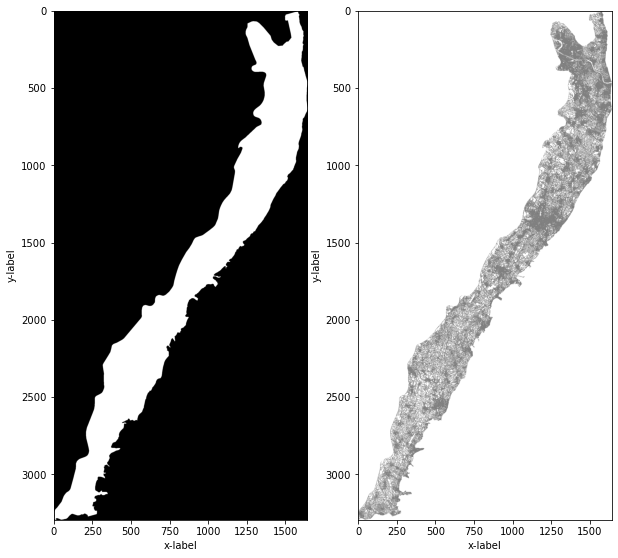

In [7]:
# Plot Masks
fig, axs = plt.subplots(1,2,figsize=(10, 10))
axs[0].imshow(mask_org, "binary_r")
axs[1].imshow(ext, "binary_r")
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

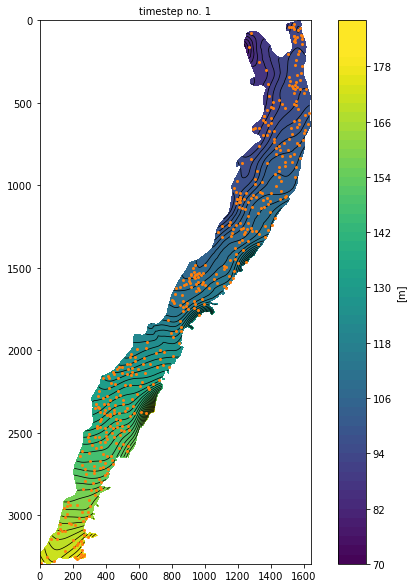

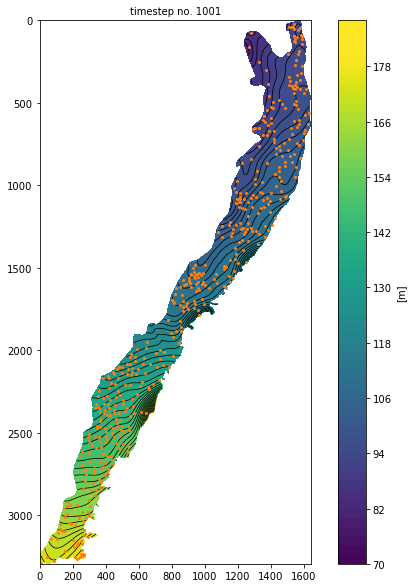

In [8]:
plt.rcParams['figure.figsize'] = [10, 10]

#plot all sensor locations
indx0=np.where(Id>0)
location0 = pd.DataFrame(list(zip(indx0[1], indx0[0])),columns =['x', 'y'])

#%% Plot exmplary snapshot of the GWL interpolations
#Define Range (roundet to 10m)
xmin=(int(X.min()/10))*10
xmax=(int(X.max()/10))*10
levels = range (xmin, (xmax+10), 2)

snapshot = float("nan")*np.ones(masks.shape)
img = 0*snapshot
temp = np.transpose(0 * X[1,:])

for i in range (0, len(gwl), 1000):
    snapshot[masks] = gwl[(i),masks]
    plt.imshow(snapshot, cmap=plt.cm.coolwarm_r)
    plt.contour(snapshot, colors='black',levels=levels, linewidths=0.75)#,  origin='upper',)
    plt.contourf(snapshot, cmap="viridis",levels=levels)#, origin='upper',)
    plt.plot(location0.x, location0.y, 'o',ms=2,color='tab:orange', label='Existing Well' )
    plt.title("timestep no. "+str(i+1), size=10)
    plt.clim(xmin,xmax)
    plt.colorbar (label= unit)
    plt.show()

In [9]:
# Global centering
x_gc=X.mean(axis=0)
X = X - x_gc
# Local centering
x_lc = X.mean(axis=1).reshape(n_samples, -1)
X = X - x_lc
print ("Min. and max. centered measured value: ", X.min().round(2), "m NN, ", X.max().round(2),  "m NN" )

Min. and max. centered measured value:  -6.16 m NN,  4.11 m NN


## Define sensor costs

In [10]:
#Ext: #Outside--> 0, Inside Mask--> 1, GWM --> 2
ext= np.where(ext == 333, Value_GWM, ext)
ext= np.where(ext == 666, Value_Mask, ext)
ext= np.where(ext == 999, Value_Outside, ext)
ext1=ext+(mask_org*0)
#Mask and reshaping
temp= ext1[masks]
temp1= mask_gwm[masks]
costs = np.reshape(temp.compressed(), temp.shape)

In [11]:
unique, counts = np.unique(costs, return_counts=True)
print("Number of pixels with cost: " ,dict(zip(unique, counts)))

Number of pixels with cost:  {0.0: 480, 21.0: 611161, 22.0: 317130}


In [12]:
# Using the cost-constrained QR algorithm (CCQR) 
optimizer = ps.optimizers.CCQR(sensor_costs=costs)

Perform Train and test split (80/20):

In [13]:
#Train and Test data
tdata = int(len(X)*0.8)
X_train, X_test = X[:tdata], X[tdata:]

print("train data:", len(X_train), ", test data:", len(X_test)) 
print("train data:", round(((tdata/len(X))*100)), "%", ", test data:", 100-round(((tdata/len(X))*100)), "%")
print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)
print('Shape of X (samples, sensors):', X.shape)
print ("Min. and max. measured centered value: ", X.min(), "m NN, ", X.max(),  "m NN" )

train data: 1043 , test data: 261
train data: 80 % , test data: 20 %
Number of samples: 1304
Number of features (sensors): 928771
Shape of X (samples, sensors): (1304, 928771)
Min. and max. measured centered value:  -6.1565866 m NN,  4.1078863 m NN


In [14]:
n_sensors=int((480*Percent*0.01))
model = ps.SSPOR(optimizer=optimizer,
     n_sensors= n_sensors)
model.fit(X_train, seed=seed)

sensors = model.get_selected_sensors()
print(model)

SSPOR(basis=Identity(n_basis_modes=1043), n_sensors=480,
      optimizer=CCQR(sensor_costs=array([21., 21., 21., ..., 22., 22., 22.])))


In [15]:
#Get location of selected sensors
indx_sensors=np.where(Id>0)
location_sensors = pd.DataFrame(list(zip(indx_sensors[1], indx_sensors[0])),columns =['x', 'y'])

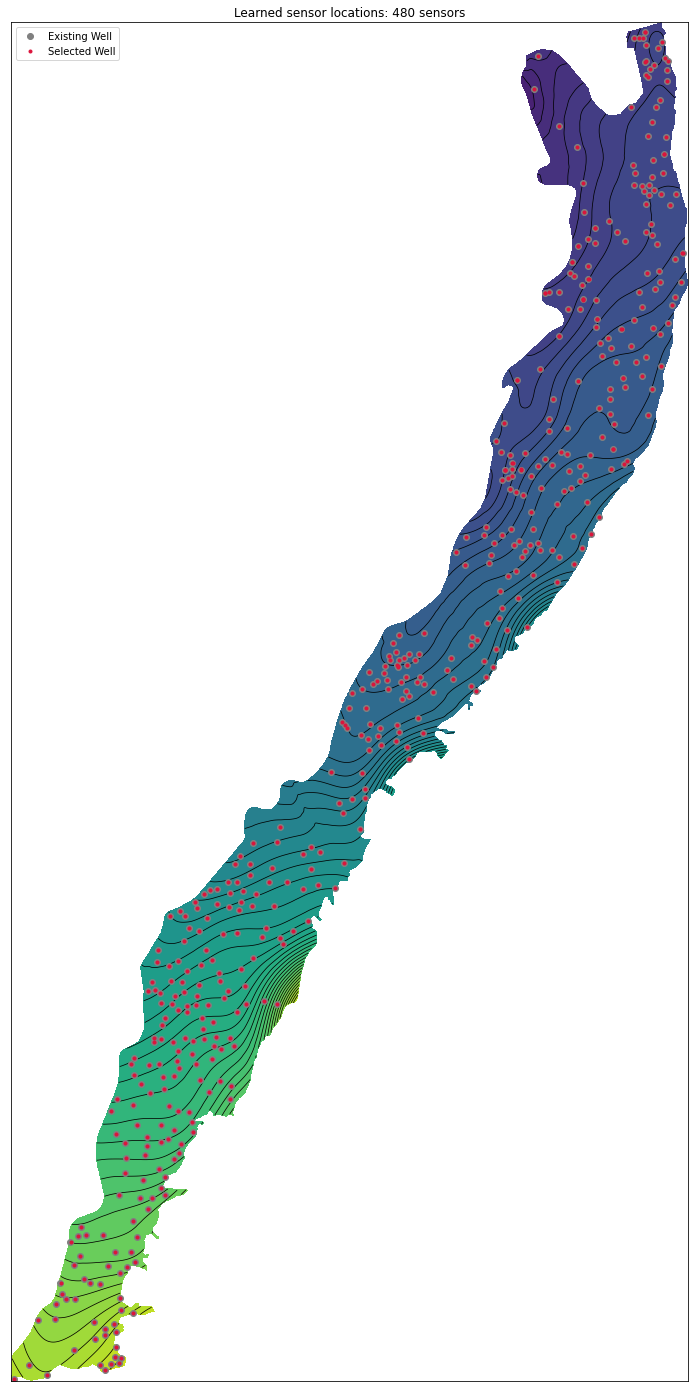

In [16]:
plt.rcParams['figure.figsize'] = [25, 25]
plt.rc("pdf", fonttype=42)
# Plot sensor locations
temp = np.transpose(0 * X[1,:])
temp[sensors] = 1
img = 0*snapshot
img[masks] = temp
plt.imshow(snapshot, cmap=plt.cm.coolwarm_r)
plt.contourf(snapshot ,cmap=plt.cm.viridis,levels=levels)
plt.contour(snapshot, colors='black',levels=levels, linewidths=0.75)

indx = np.where(img==1)
indx0=np.where(Id>0)
location0 = pd.DataFrame(list(zip(indx0[1], indx0[0])),columns =['x', 'y'])
location= pd.DataFrame(list(zip(indx[1], indx[0])),columns =['x', 'y'])
plt.plot(location0.x, location0.y, 'o',ms=6,color='grey',label='Existing Well' )
plt.plot(location.x, location.y, 'o',ms=3, color='crimson',label='Selected Well')
plt.legend()

plt.rcParams['figure.figsize'] = [25, 25]
plt.xticks([])
plt.yticks([])
plt.title('Learned sensor locations: '+ str(n_sensors)+ " sensors");
#plt.savefig("results/Location_"+str(Percent)+"P_weight("+str(Value_GWM)+"_"+str(Value_Mask)+"_"+str(Value_Outside)+").pdf", bbox_inches="tight")

In [17]:
# Subsample data so we only have measurements at chosen sensor locations
X_test_subsampled = X_test[:, sensors]
X_train_subsampled = X_train[:, sensors]

# Form reconstructions
X_test_reconstructed = model.predict(X_test_subsampled)
X_train_reconstructed = model.predict(X_train_subsampled)

In [18]:
#Rescaling
#Rescaling
X = np.append(X_train, X_test, axis=0)
X += x_lc
X += x_gc
X_train, X_test = X[:tdata], X[tdata:]

X_reconstructed= np.append(X_train_reconstructed, X_test_reconstructed, axis=0) # appending in one array
X_reconstructed+= x_lc # local centering
X_reconstructed+= x_gc # global recentering

X_train_reconstructed, X_test_reconstructed = X_reconstructed[:tdata], X_reconstructed[tdata:] # splitting in train and test

In [19]:
del X_train 
del X_train_reconstructed

In [20]:
vmin= xmin
vamx = xmax
n_row, n_col = 1, 5
n_components = n_row * n_col
image_shape = snapshot.shape
norm = mpl.colors.Normalize(vmin=xmin, vmax=xmax)

#Plot X_Test
xmin=(int(X.min()/10))*10
xmax=(int(X.max()/10))*10
levels = range (xmin, (xmax+10), 2)

lst = []
for i, comp in enumerate(X_test):
    plt.rcParams['figure.figsize'] = [20, 20]
    img = 0*snapshot
    img[masks] = comp
    img.reshape(image_shape)
    ###Plot
#     plt.imshow(img, "viridis")
#     plt.contourf(img ,cmap=plt.cm.viridis_r,levels=levels)
#     plt.colorbar (label="gw-level, m NN")
#     plt.contour(img, colors='black',levels=levels, linewidths=0.75)
#     plt.plot(location0.x, location0.y, 'o',ms=4,color='black' )
#     #plt.plot(location .x, location .y, 'o',ms=2, color='crimson')
#     plt.title("Test-Surface with all sensors, Timestep: "+str(i+1), size=20)
#     plt.clim(0,50)
#     plt.show()

    ####
    lst.append(img)
X_TEST=np.array(lst)

In [21]:
#Plot X_Test
lst = []
for i, comp in enumerate(X_test_reconstructed):
    plt.rcParams['figure.figsize'] = [20, 20]
    img = 0*snapshot
    img[masks] = comp
    img.reshape(image_shape)
    ###Plot
#     plt.imshow(img, "viridis_r")
#     plt.contourf(img ,cmap=plt.cm.viridis_r,levels=levels)
#     plt.colorbar (label="gw-level, m NN")
#     plt.contour(img, colors='black',levels=levels, linewidths=0.75)
#     plt.plot(location0.x, location0.y, 'o',ms=4,color='gray' )
#     plt.plot(location .x, location .y, 'o',ms=4,color='crimson')
#     plt.title("Reconstructed-Surface "+str(i+1)+",  No. sensors: "+ str(n_sensors), size=20)
#     plt.show()

    ####
    lst.append(img)
X_TEST_RECONSTRUCTED=np.array(lst)

In [22]:
del X
del X_reconstructed
del X_test
del X_test_reconstructed

In [23]:
ERROR=X_TEST-X_TEST_RECONSTRUCTED
max1=int(np.nanmax(ERROR))
xmin1=int(np.nanmin(ERROR))
ERROR1 = ERROR[~np.isnan(ERROR)]

In [24]:
ERROR2=np.absolute(ERROR1)

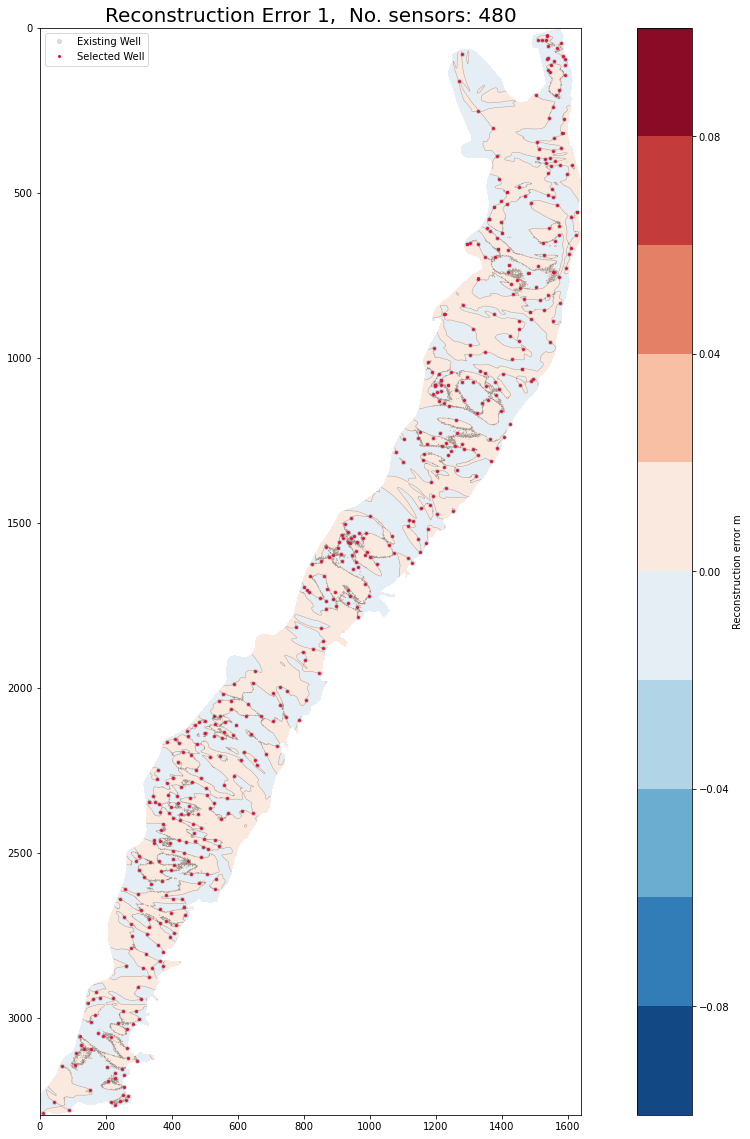

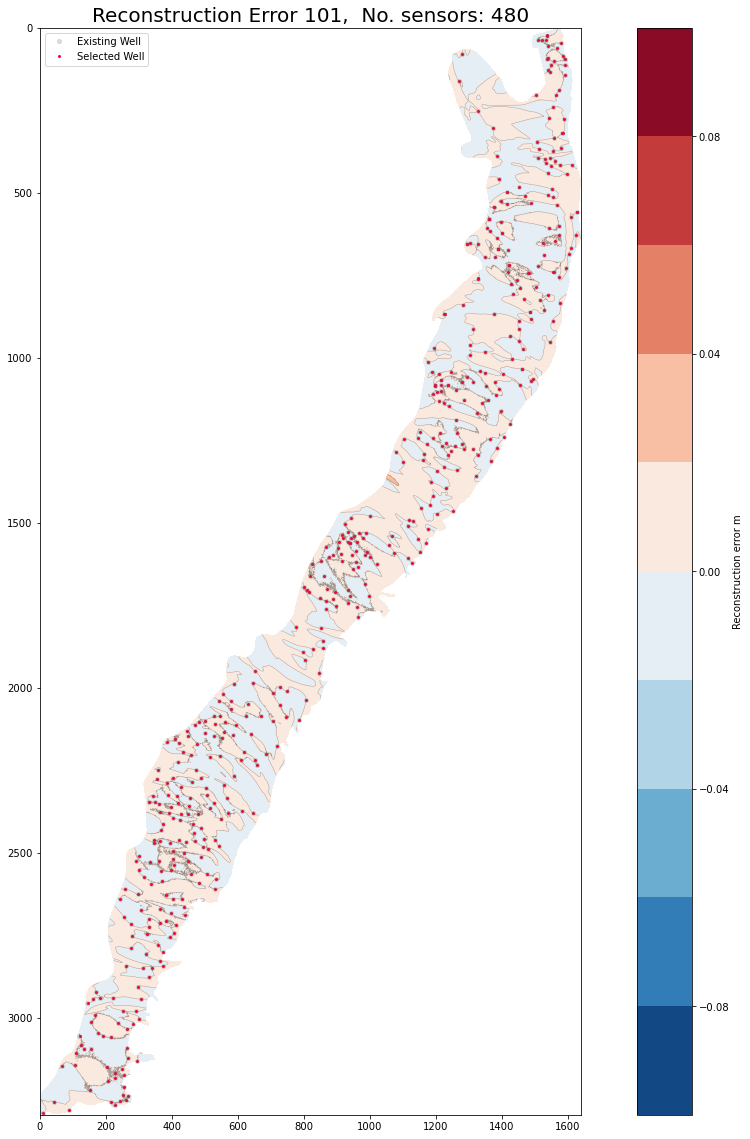

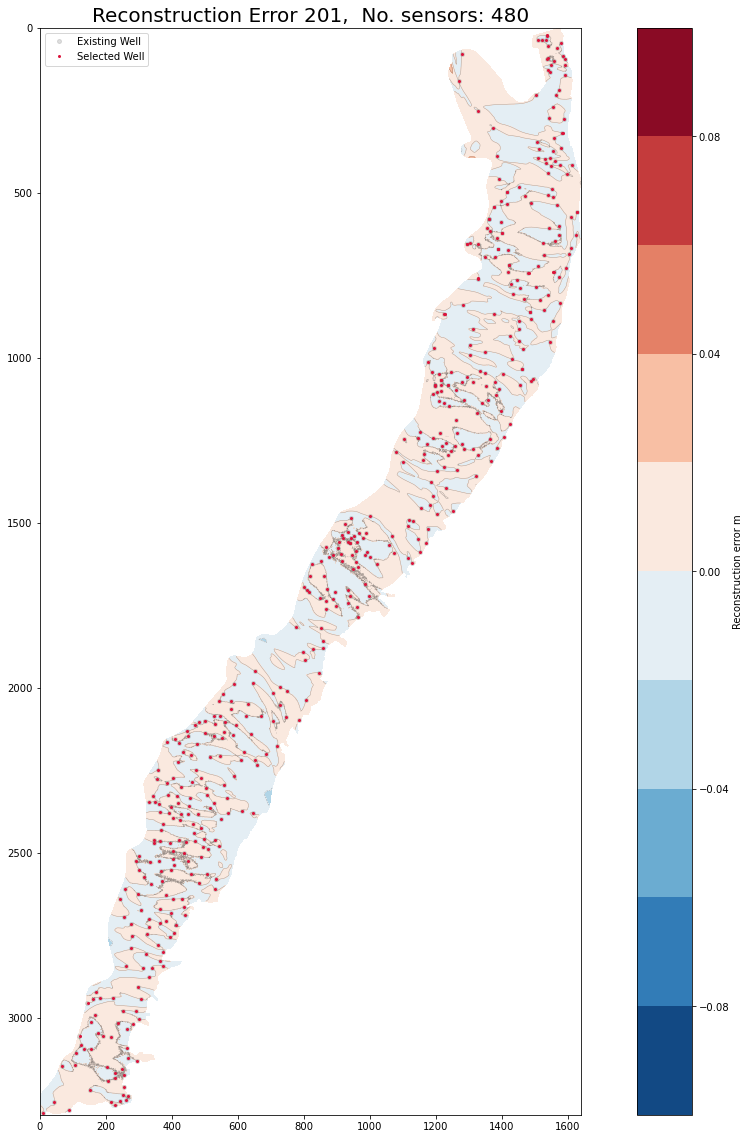

In [25]:
levels1= np.linspace(-0.1,0.1,11)
#levels2= np.linspace(-0.1,0.1,11)
#levels2= np.linspace(-0.2,0.2,11)
min_MAE=[]; max_MAE=[]; mean_MAE= []

for i in range (0, len(ERROR), 100):
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.rc("pdf", fonttype=42)
    snapshot[masks] = ERROR[(i),masks]
    plt.imshow(snapshot, cmap="RdBu_r")   
    plt.contour(snapshot,colors='black', linewidths=0.5,alpha=0.3,levels=levels1)
    plt.contourf(snapshot,  cmap= "RdBu_r",levels=levels1)#, origin='upper',)
    plt.plot(location0.x, location0.y, 'o',ms=4,color='gray',alpha=0.25,label='Existing Well' )
    plt.plot(location .x, location .y, 'o',ms=2,color='crimson',label='Selected Well')
    plt.legend()  
    plt.title("Reconstruction Error "+str(i+1)+",  No. sensors: "+ str(n_sensors), size=20)
    #plt.clim(xmin,xmax)
    plt.colorbar (label="Reconstruction error m", )
    #plt.savefig("figures/spatial/fix/Spat_Rec_fix_"+str(i)+".pdf", bbox_inches="tight")
    plt.show()
         
    ME=np.nanmean(snapshot);MAE=np.nanmean(abs(snapshot)); 
    MAX=np.nanmax(abs(snapshot));MIN=np.nanmin(abs(snapshot))
    min_MAE.append(MIN)
    max_MAE.append(MAX)
    mean_MAE.append(MAE)  
    #print("Mean Reconstrcution Error:",ME.round(3), "m")
    #print("Max. Reconstrcution Error:",MAX.round(3), "m")
    #print("Mean Absolute Reconstrcution Error:", MAE.round(3), "m")   

In [26]:
sensors
df= pd.DataFrame(data=sensors, columns=["pixel"])
df.index.names = ['rank']
df.index = df.index+1
df["Rank"]=df.index
df.set_index("pixel", drop=True, append=False, inplace=True)


In [27]:
location_sensors = pd.DataFrame(list(zip(indx_sensors[1], indx_sensors[0])),columns =['x', 'y'])
location_sensors["pixel"]=location_sensors.index+1
location_sensors.set_index("pixel", inplace=True)